In [1]:
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator, load_img
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import random
import shutil

Using TensorFlow backend.


Move and rename all files into one file

In [ ]:
count = 1
for x in files:
    for y in sorted(os.listdir("mask/"+x),key = lambda x:int(x.split('.')[0])):
        new_name = "all(ML)/"+str(count)+'.jpg'
        os.rename("mask/"+x+"/"+y,new_name)
        count += 1

Contruct dataset

In [3]:
images = []
for file in sorted(os.listdir("all(ML)") , key = lambda x:int(x.split(".")[0][0:])):
    images.append(file)

In [4]:
images = np.array(images)
images.shape

(81000,)

In [5]:
types = []
count = 1
for x in sorted(os.listdir("mask") , key = lambda x:int(x[0:])):
    for y in range(len(os.listdir('mask/'+x))):
        types.append(x)
    count+=1

In [6]:
types = np.array(types)
types.shape

(81000,)

In [7]:
df = pd.DataFrame({
    "images" : images,
    "types" : types
})

In [8]:
df.head()

,images,types
0,1.jpg,1
1,2.jpg,1
2,3.jpg,1
3,4.jpg,1
4,5.jpg,1


Visualization of dataset

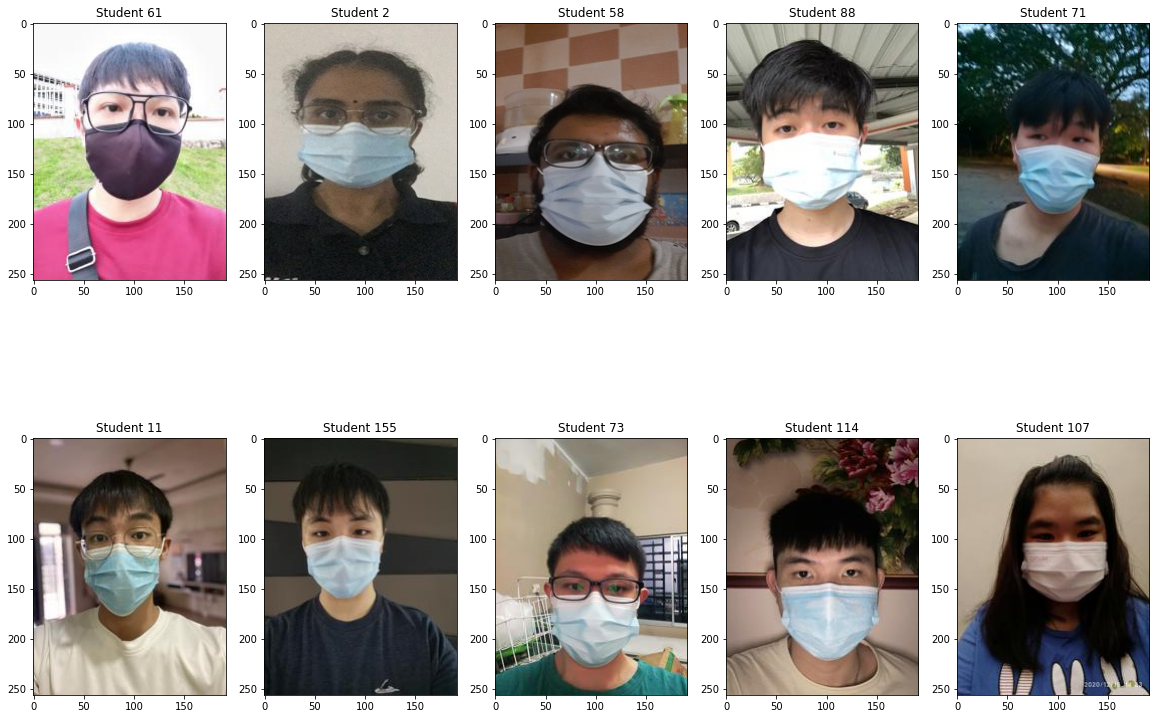

In [9]:
count = 10
images = df.sample(n=10)
plt.figure(figsize=(20,14))
for x in range(count):
    plt.subplot(2,5,x+1)
    img = cv2.imread("all(ML)/"+images.iloc[x][0])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.title("Student {}".format(images.iloc[x][1]))
    plt.imshow(img)

Split into training/validation/testing set

In [10]:
X_train_df, X_test_df = train_test_split(df,test_size=0.2, random_state=1)
X_train_df = pd.DataFrame(X_train_df)
X_test_df = pd.DataFrame(X_test_df)

In [11]:
print(X_train_df.shape)
print(X_test_df.shape)

(64800, 2)
(16200, 2)


In [12]:
# second time for validation set 
X_train_df, X_val_df = train_test_split(X_train_df, test_size=0.25, random_state=1)
X_train_df = pd.DataFrame(X_train_df)
X_val_df = pd.DataFrame(X_val_df)

In [13]:
print(X_train_df.shape)
print(X_val_df.shape)

(48600, 2)
(16200, 2)


Data Preprocessing (Data Augmentation)

In [15]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
train_generator = train_datagen.flow_from_dataframe(
    dataframe = X_train_df,
    directory = "all(ML)",
    x_col = 'images',
    y_col = 'types',
    target_size = (128,128),
    class_mode = 'categorical',
    batch_size = batch_size
)
validation_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe = X_val_df,
    directory = "all(ML)",
    x_col = 'images',
    y_col = 'types',
    target_size = (128,128),
    class_mode = 'categorical',
    batch_size = batch_size
)

Found 48600 validated image filenames belonging to 162 classes.
Found 16200 validated image filenames belonging to 162 classes.


In [54]:
test_datagen = ImageDataGenerator(
    rescale=1./255
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe = X_test_df[:100],
    directory = "all(ML)",
    x_col = 'images',
    y_col = None,
    target_size = (128,128),
    class_mode = None,
    shuffle = False
)

Found 100 validated image filenames.


Plot image on data augmentation

In [17]:
example_df = X_train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "All(ML)", 
    x_col='images',
    y_col='types',
    target_size=(128,128),
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


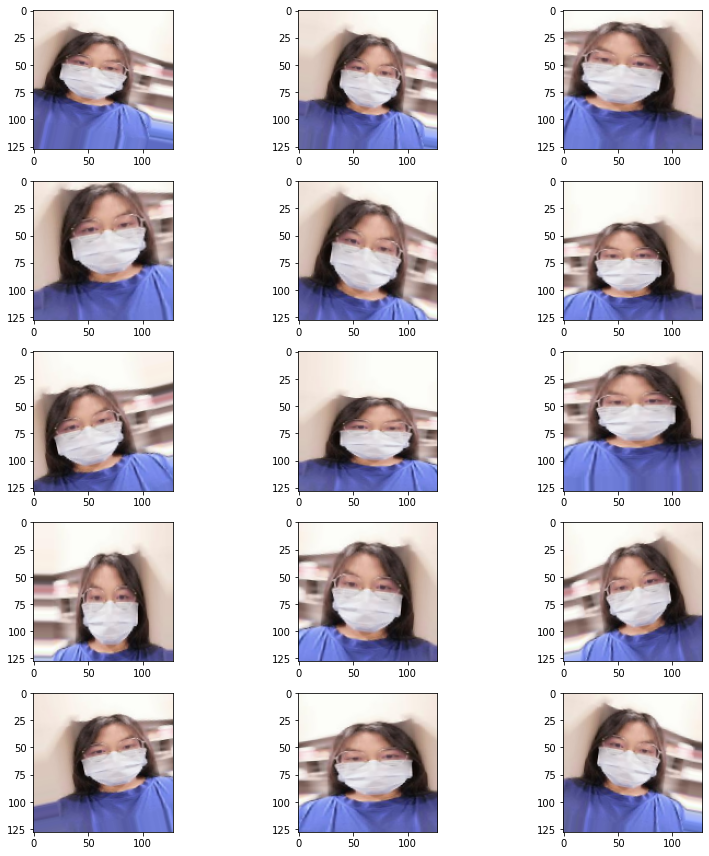

In [18]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

Early stoppping

In [20]:
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',mode = 'min',patience = 5,verbose=1)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.0001)

callbacks = [early_stop, learning_rate_reduction]

Construct CNN

In [21]:
model = keras.Sequential([
    keras.layers.Conv2D(32, (3,3),padding='same',activation = 'relu', input_shape =(128,128,3)),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(64,(3,3),padding='same',activation = 'relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(64,(3,3),padding='same',activation = 'relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(128,(3,3),padding='same',activation = 'relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation = 'relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(162,activation = 'softmax')
])

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)       

In [23]:
optimizer = keras.optimizers.Adam(lr=0.001)
model.compile(loss = 'categorical_crossentropy',optimizer = optimizer, metrics = ['accuracy'])

In [86]:
total_validate = X_val_df.shape[0]
total_train = X_train_df.shape[0]
batch_size = 16
epochs = 50

In [62]:
history = model.fit_generator(
    train_generator, 
    epochs = epochs,
    validation_data = validation_generator, 
    validation_steps = total_validate//batch_size, 
    steps_per_epoch = total_train//batch_size,
    callbacks = callbacks
)

Epoch 1/50
3037/3037 [==============================] - 4279s 1s/step - loss: 1.6583 - accuracy: 0.5927 - val_loss: 0.2094 - val_accuracy: 0.8236
Epoch 2/50
3037/3037 [==============================] - 4064s 1s/step - loss: 0.5965 - accuracy: 0.8310 - val_loss: 0.6884 - val_accuracy: 0.7578
Epoch 3/50
3037/3037 [==============================] - 3782s 1s/step - loss: 0.4245 - accuracy: 0.8768 - val_loss: 0.2473 - val_accuracy: 0.9076
Epoch 4/50
3037/3037 [==============================] - 3768s 1s/step - loss: 0.3477 - accuracy: 0.8990 - val_loss: 0.1974 - val_accuracy: 0.9343
Epoch 5/50
3037/3037 [==============================] - 3756s 1s/step - loss: 0.2831 - accuracy: 0.9160 - val_loss: 0.2288 - val_accuracy: 0.8856
Epoch 6/50
3037/3037 [==============================] - 3727s 1s/step - loss: 0.2492 - accuracy: 0.9245 - val_loss: 0.0726 - val_accuracy: 0.9453
Epoch 7/50
3037/3037 [==============================] - 3811s 1s/step - loss: 0.2188 - accuracy: 0.9343 - val_loss: 0.1044 -

Visualization of model performance

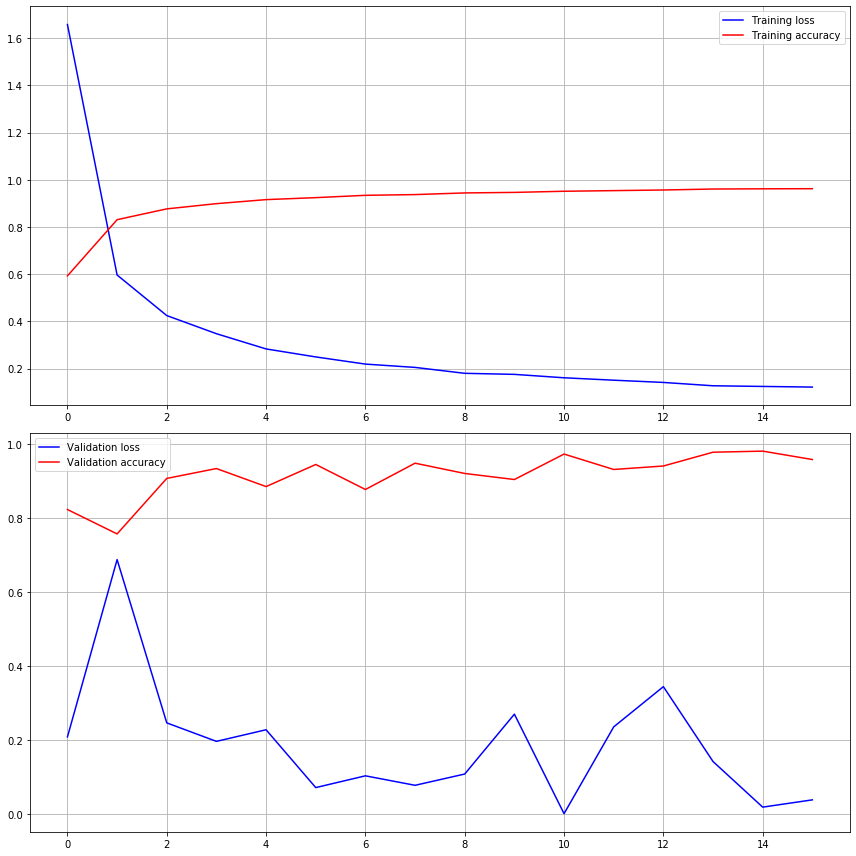

In [75]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(12,12))
ax1.plot(model.history.history['loss'],color='b',label='Training loss')
ax1.plot(model.history.history['accuracy'],color='r',label='Training accuracy')
ax2.plot(model.history.history['val_loss'],color='b',label='Validation loss')
ax2.plot(model.history.history['val_accuracy'],color='r',label='Validation accuracy')
ax1.grid(True)
ax2.grid(True)
plt.tight_layout()
ax1.legend()
ax2.legend()
plt.show()

Save Model

In [76]:
model.save('MedicalMask.h5')

Load the Model

In [24]:
model_predict = keras.models.load_model('MedicalMask.h5')

Prediction with first 100 samples

In [58]:
predict = model_predict.predict_generator(test_generator)
answer = np.argmax(predict,axis=-1)
X_test = X_test_df[:100]
X_test['types'] = answer

D:\Conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [61]:
label = dict((class_names,label) for label,class_names in train_generator.class_indices.items())
X_test = X_test['types'].replace(label)

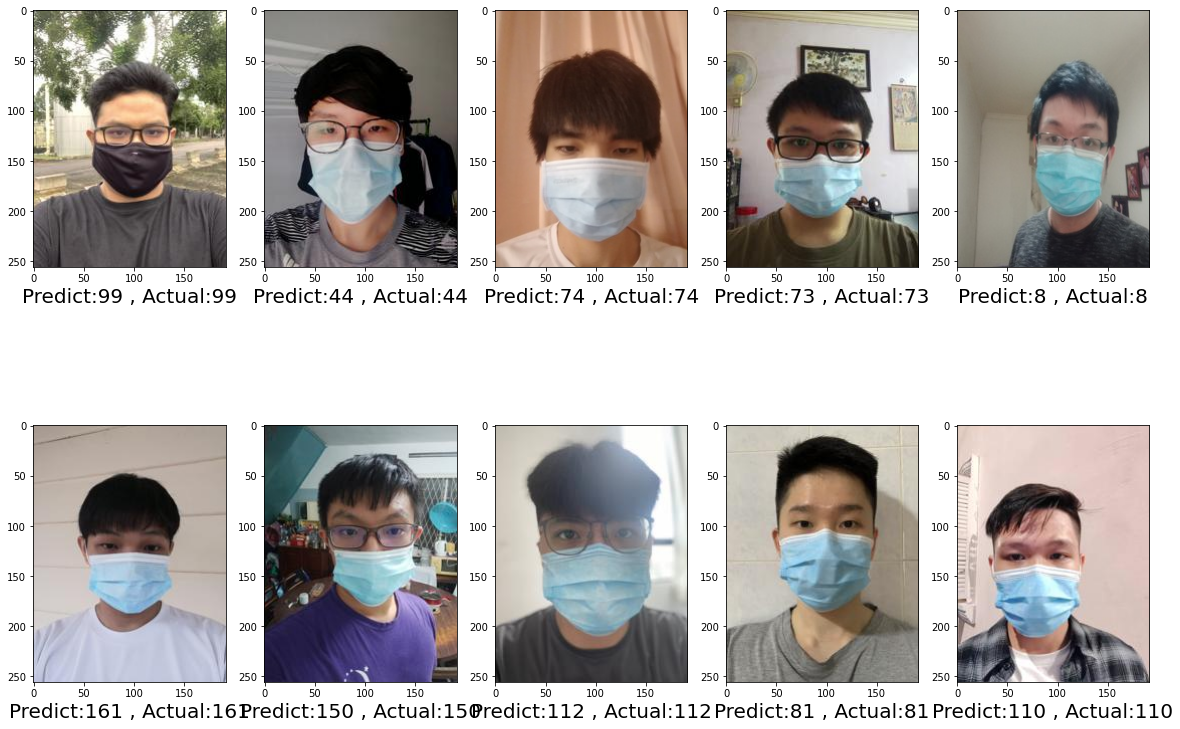

In [84]:
count = 10
images = X_test[:10]
plt.figure(figsize=(20,14))
for x in range(count):
    plt.subplot(2,5,x+1)
    img = cv2.imread("all(ML)/"+str(int(images.iloc[x])*500)+'.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.xlabel("Predict:{} , Actual:{}".format(images.iloc[x],X_test.iloc[x]),fontsize=20)
    plt.imshow(img)